# 금융 자료 분석 - S&P 500 주식 가격 예측
## Financial Data Analysis: S&P 500 stock price prediction
---

# 프로젝트 과정

## 0. 프로젝트 환경
- Python 3.6
- Pandas 0.20.1
- Numpy 1.12.1
- Beautiful Soup 4 4.6.0
- Matplotlib 2.0.2
- Scikit-learn 0.18.1
- Tensorflow 1.0.0 (CPU only)

## 1. 데이터 수집

#### 프로젝트에 사용한 세 가지 데이터
- S&P 500 지수에 포함된 기업의 주식 목록
  - S&P 500 지수는 국제 신용평가기관인 미국의 Standard and Poors(S&P)이 작성한 주가 지수이다.
  - 다우존스 지수와 마찬가지로 뉴욕증권거래소에 상장된 기업의 주가 지수이다.
  - 지수 산정에 포함되는 기업수는 시가총액 기준 상위 500개이고 포함된 주식수는 505개이다.
  - S&P 500에 포함된 주식수가 505개인 이유는 5개 기업이 두 개 클래스(의결권 다름)로 나눠진 주식을 가지고 있기 때문이다.
  - 지수에 포함된 주식이 전체 미국 주식시장 시가총액의 80%를 차지하기 때문에 시장 전체 동향 파악이 용이하다.
- S&P 500 포함 주식 가격 정보
  - S&P 500 포함 기업의 일별 주식 정보를 가져온다.
  - 일별 주식 정보는 날짜(Date), 시작가(Open), 최고가(High), 최저가(Low), 마감가(Close), 체결량(Volume)을 포함한다.
- S&P 500 지수(SPX)
  - 야후 파이낸스에서 수동으로 수집

### 1.1 S&P 500 기업 목록 수집
- 위키피디아의 ["List of S&P 500 companies"](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) 페이지로에서 S&P 500에 포함된 주식 약어(Ticker)를 수집한다.
- 수집한 목록은 여러 번 재사용 할 수 있도록 pickle 파일로 저장한다.
- 2017년 6월 1일 기준 S&P 500 목록에 포함되어 있는 주식을 사용했다.

In [11]:
# Beautiful Soup 4: pulling data from HTML or XML
import bs4 as bs
# Basic date and time types
import datetime as dt
# Miscellaneous operating system interfaces
import os
# Python Data Analysis Library
import pandas as pd
# Remote data access for pandas
import pandas_datareader.data as web
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure
import pickle
# HTTP library
import requests

# Set an width of the display in characters
pd.set_option('display.width', 300)
# Set a maximum rows to display
pd.set_option('display.max_rows', 10)
# Set a maximum columns to display
pd.set_option('display.max_columns', 10)


def save_sp500_tickers():
    """Getting tickers from a "list of S&P 500 companies", Wikipedia.
    Saving the tickers list into a pickle file.
    :return: give tickers list to get_data_from_google(reload_sp500=True)
    """
    # Get the list webpage and assign it resp
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

    # Convert the html source code into python objects using lxml parser
    soup = bs.BeautifulSoup(resp.text, 'lxml')

    # Find 'wikitable sortable' class in the HTML source code
    table = soup.find('table', {'class': 'wikitable sortable'})

    # Define a list for saving the S&P 500 tickers
    tickers = []

    # Get S&P 500 component tickers from the table, and append it to tickers list
    # Start from 1 to ignore the table header
    # tr (table row), td (table data)
    for row in table.findAll('tr')[1:]:
        # First column is the ticker symbol of companies.
        ticker = row.findAll('td')[0].text

        # Append each ticker to the 'tickers' list
        tickers.append(ticker)

    # Save the tickers list using the highest protocol available
    # Open a pickle file in binary mode: 'wb' to write it, and 'rb' to read it
    with open('sp500tickers.pickle', 'wb') as f:
        # Write a pickled representation of obj.
        pickle.dump(tickers, f)

    return tickers

save_sp500_tickers()


### 1.2 S&P 500 포함 주식의 과거 가격 정보 수집
- 앞서 저장한 Ticker를 기반으로 해당 주식들의 과거 가격 정보를 수집한다.
- Pandas 라이브러리에서 제공하는 DataReader를 사용해 주식 가격 정보를 수집한다.
- 구글 파이낸스 주식 정보에는 날짜(Date), 시작가(Open), 최고가(High), 최저가(Low), 마감가(Close), 체결량(Volume)이 포함되어 있다.
- 수집 기간은 2007년 6월 1일부터 2017년 5월 31일까지로 최근 10년을 기준으로 설정했다.

In [12]:
def get_data_from_google(reload_sp500=False):
    """Gathering S&P 500 component stock price data from Google finance.
    Saving each stock price data as csv file.
    :param reload_sp500: boolean
    :return: none
    """
    # Regathering S&P 500 list when reload_sp500=True
    if reload_sp500:
        tickers = save_sp500_tickers()

    # Otherwise, load the saved list
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)

    # Make a 'data' directory if it doesn't exist
    if not os.path.exists('data'):
        os.mkdir('data')

    # Set a date range for gathering data
    start = dt.datetime(2007, 6, 1)
    end = dt.datetime(2017, 5, 31)

    # Iterate for getting and saving stock price data by ticker
    for ticker in tickers:
        # 'ticker' is an item in 'tickers' list
        print(ticker)

        try:
            # f-string literal (f"{}" or f'{}') performs a string formatting operation
            if not os.path.exists(f'data/{ticker}.csv'):
                # Gather stock price data from Google Finance using Pandas DataReader
                df = web.DataReader(ticker, 'google', start, end)

                # Save the dataframe as csv file
                df.to_csv(f'data/{ticker}.csv')

            else:
                print(f"Already have {ticker}.csv")

        except:
            print(f"Can't load {ticker} data.")

get_data_from_google()


### 1.3 수동으로 주식 가격 수집 및 변환
- 데이터 수집 중 오류가 발생한 세 개 주식(LMT, NBL, NWL)의 가격 정보는 구글 파이낸스에서 수동으로 수집한다.
- 자동으로 수집한 주식 가격 정보와 동일한 형태로 변환한다.
- 총 505개 주식 데이터 수집 완료

In [13]:
def convert_format(*args):
    """Converting a format of data.
    :param args: ticker symbols
    :return: none
    """
    # Get tickers from args and save it to a list
    tickers = [t for t in args]

    for ticker in tickers:
        df = pd.read_csv(f'raw/{ticker}.csv')

        # Change str to date type (e.g. 15-Nov-16  >>  2016-11-15)
        df['Date'] = pd.to_datetime(df['Date'])

        # Set the DataFrame index (row labels) using one or more existing columns
        # By default, set_index() yields a new object.
        # The inplace parameter is for modifying the DataFrame in place (doesn't create a new object).
        # Set 'Date' as an index key
        df.set_index('Date', inplace=True)

        # Sort date in ascending order (default)
        df.sort_index(axis=0, inplace=True)

        df.to_csv(f'data/{ticker}.csv')

        print(ticker)
        print(df, end='\n\n')

convert_format('LMT', 'NBL', 'NWL')


LMT
              Open    High     Low   Close   Volume
Date                                               
2007-06-01   98.23   98.60   97.09   97.43  1559200
2007-06-04   96.98   97.41   96.85   97.20  1076400
2007-06-05   96.70   96.70   95.11   96.20  2225091
2007-06-06   96.20   96.99   95.95   96.65  2556500
2007-06-07   97.54   99.35   95.25   95.25  2227800
...            ...     ...     ...     ...      ...
2017-05-24  278.22  280.56  278.11  280.05   872150
2017-05-25  281.00  282.33  280.56  282.06   834315
2017-05-26  282.04  284.00  281.54  283.65   854649
2017-05-30  281.83  282.84  279.73  280.09   902223
2017-05-31  279.47  281.28  279.27  281.13  1506621

[2518 rows x 5 columns]

NBL
              Open    High     Low   Close   Volume
Date                                               
2007-06-01  112.95  114.12  112.43  112.80   815424
2007-06-04  112.95  117.34  112.82  116.96   995244
2007-06-05  115.86  116.05  114.12  115.59   823375
2007-06-06  115.38  115.38  11

### 1.4 수집한 주식 가격 정보 통합
- 수집한 데이터의 전처리와 활용의 용이함을 위해 두 개의 CSV 파일을 생성한다.
- 'sp500-closes.csv' : 505개 주식의 마감가격을 ticker 약어로 변경한 데이터를 포함한다.
- 'sp500-closes-volumes.csv' : 주식의 마감가격과 체결량을 포함한다.

In [15]:
def compile_data():
    """Merging multiple csv files merged into a main csv file.
    Compiling all the stock price data into one data frame, and removing unnecessary columns.
    :return: none
    """
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)

    # DataFrame is 2D size-mutable,
    # potentially heterogeneous tabular data structure with labeled axes (rows & columns)
    main_df_closes, main_df_cnv = pd.DataFrame(), pd.DataFrame()

    # Create csv for daily close values per ticker
    # 'enumerate' built-in function returns an enumerate object one by one.
    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv(f'data/{ticker}.csv')
            df.set_index('Date', inplace=True)

            # 'columns' parameter: dict-like or functions are transformations to apply to that axis’ values
            df.rename(columns={'Close': ticker}, inplace=True)

            # Drop requested axis without creating a new object (0: row axis, 1: columns axis)
            df.drop(['Open', 'High', 'Low', 'Volume'], 1, inplace=True)

            # Joining DataFrames
            if main_df_closes.empty:
                main_df_closes = df
            else:
                # 'how' is a methods of join {‘left’, ‘right’, ‘outer’, ‘inner’}, default: ‘left’
                main_df_closes = main_df_closes.join(df, how='outer')
        except:
            pass

    print(main_df_closes)
    main_df_closes.to_csv('sp500-closes.csv')

    # Create csv for daily close price and trade volume
    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv(f'data/{ticker}.csv')
            df.set_index('Date', inplace=True)
            df.rename(columns={'Close': f'{ticker}_Close'}, inplace=True)
            df.rename(columns={'Volume': f'{ticker}_Volume'}, inplace=True)
            df.drop(['Open', 'High', 'Low'], 1, inplace=True)
            if main_df_cnv.empty:
                main_df_cnv = df
            else:
                main_df_cnv = main_df_cnv.join(df, how='outer')
        except:
            pass
    pd.set_option('display.max_columns', 5)
    print(main_df_cnv)
    pd.set_option('display.max_columns', 10)
    main_df_cnv.to_csv('sp500-closes-volumes.csv')

compile_data()


               MMM    ABT   ABBV     ACN   ATVI  ...     YHOO    YUM     ZBH   ZION    ZTS
Date                                             ...                                      
2007-06-01   88.43  28.15    NaN   41.26   9.44  ...    28.78  34.12   88.11  81.85    NaN
2007-06-04   88.07  27.81    NaN   41.24   9.56  ...    28.59  34.37   88.36  81.37    NaN
2007-06-05   87.46  27.74    NaN   41.75   9.76  ...    28.23  34.14   87.34  80.00    NaN
2007-06-06   86.62  27.37    NaN   41.00   9.78  ...    27.44  33.90   86.78  79.14    NaN
2007-06-07   84.88  26.99    NaN   39.82   9.23  ...    26.98  33.10   84.53  78.89    NaN
...            ...    ...    ...     ...    ...  ...      ...    ...     ...    ...    ...
2017-05-24  197.49  43.53  65.93  121.95  58.51  ...    50.32  71.95  119.10  40.70  62.30
2017-05-25  199.54  43.95  66.32  123.10  59.22  ...    50.60  72.13  119.30  40.88  62.58
2017-05-26  200.67  44.71  66.06  122.89  58.28  ...    50.67  72.09  119.23  40.45  62.61

## 2. 시각화를 통한 주가 분석
통합 및 간단한 전처리를 마친 주식 가격 데이터가 어떤 특징을 가지는지 알아보기 위해 시각화를 진행한다. S&P 500 지수에 가중치가 큰 상위 10개 기술 기업의 주식 간 상관관계를 확인하기 위해 히트맵을 작성했다. 그리고 분석 범위를 줄이기 위해 Big 5 Technology Giants(Alphabet, Amazon, Apple, Facebook, Microsoft)로 불리는 기업의 주식을 중점으로 프로젝트를 진행했다.

### 2.1 주가 그래프 예제

#### 2.1.1 한 가지 주식에 대한 마감가격, 이동 평균선과 체결량

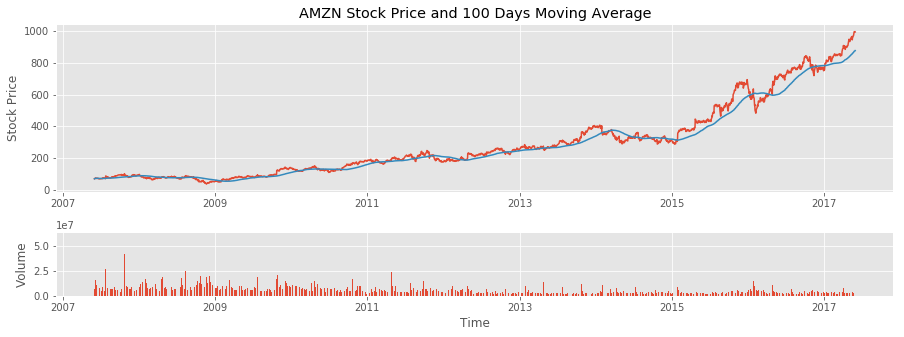

In [4]:
# Python 2D plotting library
import matplotlib as mpl
from matplotlib import style
# Pyplot provides a MATLAB-like plotting framework
import matplotlib.pyplot as plt
import pandas as pd

# Change the default rc settings
mpl.rcParams['figure.figsize'] = (15, 5)
# ggplot is a plotting system for Python based on R's ggplot2
style.use('ggplot')


def visualize_ticker(ticker):
    """Visualizing a stock with a moving average"""
    df = pd.read_csv('sp500-closes-volumes.csv', parse_dates=True, index_col=0)

    # 100 days rolling moving average
    df[f'{ticker}_100MA'] = df[f'{ticker}_Close'].rolling(window=100, min_periods=0).mean()

    ax1 = plt.subplot2grid((8, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8, 1), (6, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(df.index, df[f'{ticker}_Close'])
    ax1.plot(df.index, df[f'{ticker}_100MA'])
    ax2.bar(df.index, df[f'{ticker}_Volume'])

    ax1.set_title(f'{ticker} Stock Price and 100 Days Moving Average')
    ax1.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volume')

    plt.show()

# Visualize one stock with 100 days moving average
visualize_ticker('AMZN')


#### 2.1.2 여러 주식 그래프와 이동 평균선

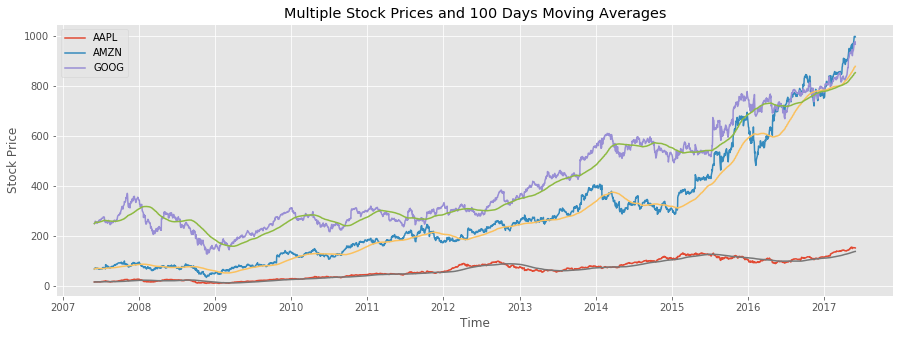

In [5]:
def visualize_tickers(*args):
    """Visualizing multiples stocks with moving averages"""
    df = pd.read_csv('sp500-closes.csv', parse_dates=True, index_col=0)

    tickers = [t for t in args]
    tickers_100ma, tickers_close, tickers_volume = [], [], []

    # 100 days rolling moving average
    for ticker in tickers:
        df[f'{ticker}_100MA'] = df[f'{ticker}'].rolling(window=100, min_periods=0).mean()
        tickers_100ma.append(f'{ticker}_100MA')
        tickers_close.append(f'{ticker}')

    plt.plot(df.index, df[tickers_close])
    plt.plot(df.index, df[tickers_100ma])

    plt.legend([c for c in tickers_close])
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Multiple Stock Prices and 100 Days Moving Averages')
    plt.show()

# Visualize multiple stocks
visualize_tickers('AAPL', 'AMZN', 'GOOG')

### 2.2 Big 5 Technology Giants in S&P 500
#### 2.2.1 S&P 500 상위 10개 테크 기업 주식 간 상관관계

#### S&P 500 상위 10개 테크 기업 목록

|기업명|주식 약어(Ticker)|
|:---:|:---:|
|Apple|AAPL|
|Amazon|AMZN|
|Facebook|FB|
|Alphabet(Google)|GOOG, GOOGL|
|Microsoft|MSFT|
|IBM|IBM|
|Cisco|CSCO|
|Intel|INTC|
|Oracle|ORCL|
|Visa|V|

- Amzon을 제외한 상위 10개 테크 기업의 산업분류는 Global Industry Classification Standard(GICS)에 의해 Information Technology 섹터로 분류된다.
- Amazon은 Consumer Discretionary 섹터로 분류된다.

#### 상관관계 히트맵
- Alphabet이 발행한 두 가지 주식 GOOG(의결권 있음)와 GOOGL(의결권 없음)의 주식 가격에대한 상관계수는 0.999735으로 의결권 여부와 상관없이 상관관계가 매우 높게 나타났다.
- Big 5 Technology Giants라 불리는 Apple, Amazon, Facebook, Alphabet, Microsoft의 상관계수가 높게 나타남을 시각적으로 확인 할 수 있다.
- Big 5 Tech. Giants와 Visa 주식의 상관계수 평균은 0.9565395으로 매우 높았다.
- IBM의 경우 다른 9개 기업 주식과의 상관계수 평균이 0.2495361으로 상관도가 낮았다. 특히 IBM과 Facebook 주식의 상관계수는 -0.760486으로 가장 낮은 값을 나타냈다.
- IBM과 Cisco 주식 가격의 상관계수는 -0.077303으로 중립적인 상관관계를 나타낸다.
- 같은 산업군으로 분류되는 기업 간에도 여러 상관 관계가 존재한다.

Correlation Table:
           AAPL      AMZN        FB      GOOG     GOOGL      MSFT       IBM      CSCO      INTC      ORCL         V
AAPL   1.000000  0.856765  0.780414  0.873085  0.873052  0.848100  0.597020  0.465320  0.863510  0.926349  0.912927
AMZN   0.856765  1.000000  0.931851  0.958448  0.960050  0.933230  0.351103  0.595662  0.812040  0.802792  0.942295
FB     0.780414  0.931851  1.000000  0.961022  0.964573  0.967195 -0.760486  0.883403  0.848757  0.723366  0.970667
GOOG   0.873085  0.958448  0.961022  1.000000  0.999735  0.965904  0.368258  0.672911  0.870218  0.851996  0.978408
GOOGL  0.873052  0.960050  0.964573  0.999735  1.000000  0.967025  0.359032  0.674594  0.870082  0.848638  0.979040
MSFT   0.848100  0.933230  0.967195  0.965904  0.967025  1.000000  0.268998  0.757841  0.918833  0.791409  0.955900
IBM    0.597020  0.351103 -0.760486  0.368258  0.359032  0.268998  1.000000 -0.077303  0.401367  0.658973  0.328399
CSCO   0.465320  0.595662  0.883403  0.672911  0.6745

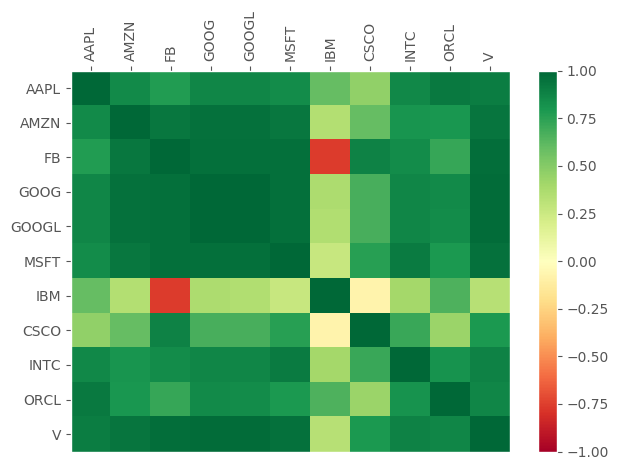

In [7]:
# Fundamental package for scientific computing
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Reset rcParams as deafault
mpl.rcParams.update(mpl.rcParamsDefault)
pd.set_option('display.width', 300)
style.use('ggplot')


def visualize_corr(*args):
    """Visualizing a heatmap of stock correlation and searching for patterns."""
    tickers = [t for t in args]
    df = pd.read_csv('sp500-closes.csv')

    # Compute pairwise correlation of columns, excluding NA/null values
    df_corr = df[tickers].corr()
    print("Correlation Table:")
    print(df_corr)
    df_corr.to_csv('top10-corr.csv')

    # Extract values from the corr table, and assign it as Numpy array
    data1 = df_corr.values

    # Define fig1 as matplotlib figure
    fig1 = plt.figure()

    # Add subplot in fig1, 111 means height, width, and plot number
    ax1 = fig1.add_subplot(111)

    # Set a color map of heatmap, pcolor: plot color, cmap: colormap
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)

    # Add colorbar to the subplot
    fig1.colorbar(heatmap1)

    # Set ticks for x and y axis
    # Numpy.arange: return evenly spaced values within a given interval
    # 0.5 is the middle (0 to 1)
    # minor=False means disable minor ticks from axis
    ax1.set_xticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[1]) + 0.5, minor=False)

    # Flip y axis for better readability
    ax1.invert_yaxis()

    # Move x axis to the top of subplot from the bottom
    ax1.xaxis.tick_top()

    # Assign labels, df_corr.columns and df_corr.index are identical
    column_labels = df_corr.columns
    row_labels = df_corr.index

    # Set tick labels for x and y axis
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)

    # Rotate x axis tick labels vertically
    plt.xticks(rotation=90)

    # Set the heatmap's color range from -1 to 1, clim: color limit
    heatmap1.set_clim(-1, 1)

    # Automatically adjust the subplot, so that fits into the figure
    plt.tight_layout()

    # Save the figure as a file
    plt.savefig('top10-corr-heatmap.png', dpi=300)

    # Display the figure
    plt.show()

# Visualize a correlation of top 10 tech. companies
visualize_corr('AAPL', 'AMZN', 'FB', 'GOOG', 'GOOGL', 'MSFT',
               'IBM', 'CSCO', 'INTC', 'ORCL', 'V')


#### 2.2.2 Big 5 Tech. Giants의 지수 가중 그래프
- 지수 가중 통계는 최근 값에 좀 더 많은 가중치를 두는 방법이므로 균등 가중 방식에 비해 좀 더 빠르게 변화를 수용한다.
- 2015년을 기점으로 Amazon과 Alphabet의 주식 가격이 급등하고 있다.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


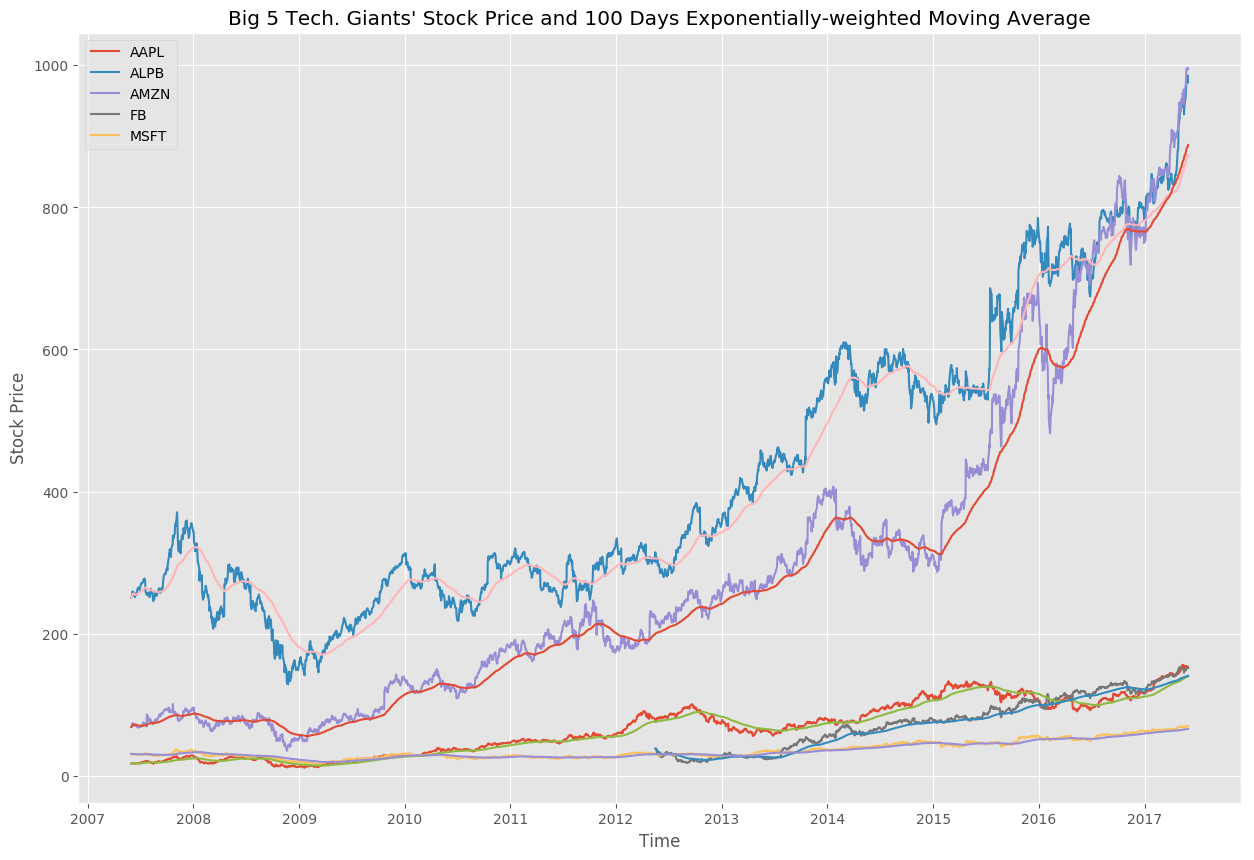

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

mpl.rcParams['figure.figsize'] = (15, 10)
style.use('ggplot')


# Big 5 Tech. Giants: Apple, Amazon, Facebook, Alphabet (Google), Microsoft
# Alphabet has two classes stocks (GOOG shares have no voting rights while GOOGL shares do).
big5 = ['AAPL', 'AMZN', 'FB', 'GOOG', 'GOOGL', 'MSFT']

df = pd.read_csv('sp500-closes.csv', parse_dates=True, index_col=0)
df_big5 = df[big5]

# Create ALPB column for Alphabet, calculate mean of GOOG and GOOGL
df_big5['ALPB'] = df_big5[['GOOG', 'GOOGL']].mean(axis=1)
df_big5.drop(['GOOG', 'GOOGL'], 1, inplace=True)
df_big5.sort_index(axis=1, inplace=True)

# Save to csv
df_big5.to_csv('big5.csv')

# Exponentially-weighted Functions
ewm100 = df_big5.ewm(span=100, min_periods=0, adjust=True, ignore_na=False).mean()

plt.plot(df_big5.index, df_big5)
plt.plot(df_big5.index, ewm100)

plt.title("Big 5 Tech. Giants' Stock Price and 100 Days Exponentially-weighted Moving Average")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(df_big5)
plt.show()


#### 2.2.3 Big 5 Tech. Giants의 6개월 수익과  S&P 500 지수의 상관관계

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=125,min_periods=100).corr(other=<DataFrame>,pairwise=True)
  del sys.path[0]


Average of six-month retun correlations to S&P 500:
AAPL 0.563594584375
ALPB 0.612732196799
AMZN 0.529797149626
FB 0.436611537071
MSFT 0.647637454214


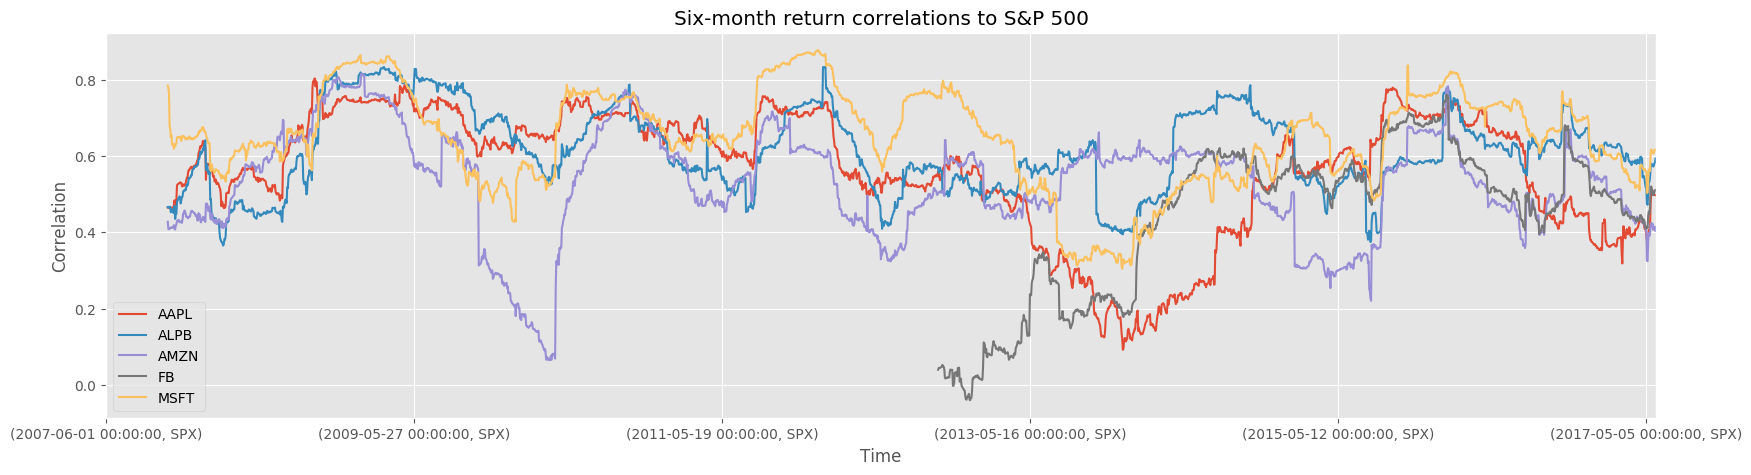

In [14]:
mpl.rcParams['figure.figsize'] = (20, 5)

# Six-month return correlations to S&P 500
# SPX: S&P 500 index, downloaded manually from Yahoo Finance
spx = pd.read_csv('raw/SPX.csv', parse_dates=True, index_col=0)
spx.rename(columns={'Adj Close': 'SPX'}, inplace=True)
spx.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

spx_rets = spx / spx.shift(1) - 1
returns = df_big5.pct_change()

# Need to fix rolling_corr() -> DataFrame.rolling().corr(another DF)
corr = pd.rolling_corr(returns, spx_rets, 125, min_periods=100, pairwise=True)
corr.dropna()

big5_list = list(df_big5.columns.values)
print('Average of six-month retun correlations to S&P 500:')
for b in big5_list:
    print(b, corr[f'{b}'].mean())

corr.plot()
plt.title('Six-month return correlations to S&P 500')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.show()


## 3. 주식 마감가격의 상승, 하락, 보합 예측
- 예측하고자 하는 주식의 마감가격이 상승, 하강, 또는 일정 구간에 보합을 보일지를 예측한다.
- Features : 예측하려는 주식을 제외한 S&P 500에 포함된 다른 모든 주식의 가격 변화율. 가격 변화율을 좀 더 정확하게 표현하면 과거 특정 날짜로부터 설정한 미래의 기간 동안의 가격 변화율.
- Target : 예측할 주식의 마감가격이 어떻게 변할 것인지(상승, 하락, 보합)
- Target Label : 1(상승), 0(보합), -1(하락)

### 3.1 특정 주식의 미래 일정 기간동안의 가격 변화율
- 예측에 사용할 미래 기간: 7일
- 가격 변화율 = (i일 미래 가격 - 현재 가격) / 현재 가격

In [28]:
# Counter is dict subclass for counting hashable objects
from collections import Counter
import numpy as np
import pandas as pd
# Open source machine learning library
from sklearn import svm, neighbors
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Calculating mathematical statistics of numeric (Real-valued) data
from statistics import mean


def prep_data_for_labels(ticker):
    """Read S&P 500 close price data and manipulate and normalize for preprocessing.
    :param ticker: a stock symbol which will be predicted
    :return: tickers, df, days
    """
    # How many days in the future we need prices for
    days = 7

    # Read daily close prices of all stocks, index is 'Date'
    df = pd.read_csv('sp500-closes.csv', index_col=0)

    # Convert ticker column names into a list
    tickers = df.columns.values.tolist()

    # Replace NA/NaN values by 0
    df.fillna(0, inplace=True)

    # Normalization: add new columns of pct. change values for the next i days
    for i in range(1, days + 1):
        # Pct. change within next i days and today's price = (future price in i days - today's price) / today's price
        # Shift index by -i periods (shift up the column by i rows)
        df[f'{ticker}_D{i}'] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]

    # Replace NA/NaN values by 0
    df.fillna(0, inplace=True)

    return tickers, df, days


### 3.2 Label class를 구분하는 기준
- target label이 imbalance되지 않도록 설정해야한다.
- 기준 : 0.5%
  - 상승 : 가격 변화율 > 0.5%
  - 하락 : 가격 변화율 < -0.5%
  - 보합 : -0.5% <= 가격 변화율 <= 0.5%
  

In [29]:
def label_classes(*args):
    """Target Labeling criteria
    :param args: every rows of f'{ticker}_{i}D' columns
    :return: 1, -1, or 0
    """
    # Put args into a list
    cols = [c for c in args]

    requirement = 0.005

    for col in cols:
        if col > requirement:
            return 1
        elif col < -requirement:
            return -1
        else:
            return 0


### 3.3 Feature, Target 설정
- 특정 주식에서 미래 예측 기간에 대한 컬럼들을 label_classes() 함수를 이용해 매핑
- 예측할 주식 외 다른 S&P 500 주식들의 가격변화율을 feature로 설정
- 앞서 매핑한 1, 0, -1 을 넣은 컬럼을 target으로 설정

In [30]:
def extract_feature_target(ticker):
    """Mapping Target Labels
    :param ticker: a stock symbol
    :return: X, y, df
    """
    # Get return values from prep_manipulation function
    tickers, df, days = prep_data_for_labels(ticker)

    # Mapping labels to the target
    df[f'{ticker}_target'] = list(map(label_classes, *[df[f'{ticker}_{i}D'] for i in range(1, days + 1)]))

    vals = df[f'{ticker}_target'].values.tolist()

    # Change vals integer into string
    str_vals = [str(i) for i in vals]

    # Counts labels by classes
    print("Target Label Spread:", Counter(str_vals))

    # Cleaning data
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    # Percent change over given number of periods.
    df_vals = df[[ticker for ticker in tickers]].pct_change(periods=1)
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    # Features: daily pct. change of all S&P 500 stocks
    X = df_vals.values

    # Target: 1, 0, -1
    y = df[f'{ticker}_target'].values

    return X, y, df


### 3.4 하나의 주식에 대한 예측
- Train과 Test 크기 비율은 7:3
- 앙상블 방법인 VotingClassifier 사용
  - 사용된 classifier : linear support vector, k-neighbors, random forest
- Principal Component Analysis를 사용해 feature 수를 줄여서 연산 시간 단축시킴
- Cross-validation은 10으로 설정

In [32]:
def classification(ticker):
    """Classify a specific stock
    :param ticker: a stock symbol
    :return: accuracy
    """
    print(ticker)

    X, y, df = extract_feature_target(ticker)

    # Split train and test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Classifiers
    clf1 = svm.LinearSVC()
    clf2 = neighbors.KNeighborsClassifier()
    clf3 = RandomForestClassifier()
    eclf = VotingClassifier(estimators=[('lsvc', clf1), ('knc', clf2), ('rfc', clf3)], voting='hard')

    # Principal Component Analysis (PCA)
    pca = PCA(n_components=10)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    pca.fit(X_test)
    X_test = pca.transform(X_test)
    
    # Cross-validation
    params = {}
    grid = GridSearchCV(estimator=eclf, param_grid=params, cv=10)
    grid = grid.fit(X_train, y_train)

    predictions = grid.predict(X_test)
    print("Predicted Label Spread:", Counter(predictions))

    accuracy = grid.score(X_test, y_test)
    print("Accuracy:", accuracy)

    return accuracy


### 3.5 모든 S&P 500 주식 예측하기

In [33]:
def classification_all():
    """Classify all S&P 500 stocks."""
    df = pd.read_csv('sp500-closes.csv', index_col=0)
    tickers = df.columns.values.tolist()

    accuracies = []

    for count, ticker in enumerate(tickers):
        try:
            accuracy = classification(ticker)
            accuracies.append(accuracy)
            # print(f"{ticker} accuracy: {accuracy}")
            print(count)
        except:
            print(f"{ticker} has only one class in label")

    print(f"Average accuracy ({count} stocks): {mean(accuracies)}")


### 3.6 Big 5 Tech. Giants 주식 예측결과
```
AAPL
Target Label Spread: Counter({'1': 984, '-1': 833, '0': 701})
Predicted Label Spread: Counter({1: 487, -1: 200, 0: 69})
Accuracy: 0.363756613757
AMZN
Target Label Spread: Counter({'1': 996, '-1': 911, '0': 611})
Predicted Label Spread: Counter({-1: 388, 1: 344, 0: 24})
Accuracy: 0.366402116402
FB
Target Label Spread: Counter({'0': 1609, '1': 486, '-1': 423})
Predicted Label Spread: Counter({0: 716, -1: 32, 1: 6})
Accuracy: 0.624668435013
GOOG
Target Label Spread: Counter({'1': 898, '0': 847, '-1': 773})
Predicted Label Spread: Counter({-1: 359, 1: 287, 0: 110})
Accuracy: 0.321428571429
GOOGL
Target Label Spread: Counter({'1': 909, '0': 828, '-1': 781})
Predicted Label Spread: Counter({1: 340, -1: 274, 0: 142})
Accuracy: 0.35582010582
MSFT
Target Label Spread: Counter({'1': 861, '0': 834, '-1': 823})
Predicted Label Spread: Counter({-1: 336, 0: 219, 1: 201})
Accuracy: 0.369047619048
Average Accuracy on Big 5: 0.400187243578
```

### 3.6 Multiprocessing Performance
- Amazon 주식을 사용해 테스트
- 테스트 결과
  - PCA(n_component=10), singleprocessing : ```1 loop, best of 3: 1.84 s per loop```
  - PCA(n_component=10), multiprocessing : ```1 loop, best of 3: 2.87 s per loop```
  - PCA(n_component=100), singleprocessing : ```1 loop, best of 3: 6.59 s per loop```
  - PCA(n_component=100), multiprocessing : ```1 loop, best of 3: 7.03 s per loop```
- 연산량이 적을 경우 singleprocessing이 유리

## 4. Long Short-term Memory(LSTM)을 이용한 주가 예측

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import os

style.use('ggplot')
tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('ggplot')


def MinMaxScaler(data):
    """ Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    """
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 200
output_dim = 1
learning_rate = 0.01
iterations = 1000

# Open, High, Low, Volume, Close
df = pd.read_csv('data/AMZN.csv')
xy = df.as_matrix(['Open', 'High', 'Low', 'Volume', 'Close'])
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# Root Mean Squared Error (RMSE)
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['testY', 'test_predict'])
    plt.show()


## 5. 향후 과제

### 단기
1. 코딩 스타일 통일: 파이썬을 배우며 프로젝트를 진행하다보니 초기 만든 코드와 나중에 만든 코드 스타일이 다르다. 예) f-string literal의 사용
2. Matplotlib 그래프를 깔끔하게 변경하자. 예) labeling
3. 예전 코드를 참고해 만들었던 기능을 최신 기준에 맞게 변경하자. 예) Pandas pd.rolling_corr(), .loc의 사용

### 중기
1. 분류 예측에서 Precision, Recall, F-measure를 이용한 예측 정확도 측정이 필요함.
2. S&P 500 포함 주식을 군집화해 빅 5 테크 기업이 어떤 그룹에 속하는지 알아보자.

### 장기
1. 주식 관련 기사 요약과 해당 기사의 감정 분석 결과를 주가 예측에 반영시켜보자.

**프로젝트 요약**
- 일반적인 주가 분석
  - 이동 평균선(Moving Average)
  - 지수 가중 이동 평균선(Exponentially-weighted Moving Average)
  - 이동 상관관계(Moving Correlation)
- 주식을 살지, 팔지, 보유해야 할 것인지 예측하자.
  - Supervised Learning에서 분류(classification) 문제
  - Features: S&P 500 기업들의 일별 주식 가격 변화율
  - Target: 예측할 주식을 세 개의 분류 클래스로 설정: buy(1), sell(-1), hold(0)
  - 목표 정확도(accuracy) > 0.33(무작위 확률)
  - 분류 알고리즘 : Linear SVC, K-Neighbors Classifier, Random Forest Classifier
  - 파라미터 값은 GridSerchCV를 통해 자동으로 선정
  - 고려 사항
    - 자료 크기를 어떻게 설정할 것인가?
      - 2000년 부터의 자료가 전부 필요한 것인지 의문이다.
      - 최근 몇 년의 자료만 사용했을 시 예측 성능이 더 좋지 않을까?
      - 최근 10년, 7년, 5년, 3년 데이터를 따로 만들어서 비교해보자.
    - 시계열 자료를 학습하기 위해 test와 train data를 구분 할 시 chronological order를 고려하지 않고 무작위로 shuffle해도 되는 건가?
    - 하나의 클래스만 예측한 경우보다 높은 정확도가 필요하다. 
      - 단순히 buy라고 예측했을 때의 정확도보다 분류 모델을 적용한 예측도를 높여보자.
    - Precision-Recall로 예측 성능을 평가하는 것이 더욱 정확하다.
    - F1 score 2PR/(P+R)구하자.
    - Feature의 수를 줄여서 예측 성능을 높을 순 없을까?
      - 주성분 분석(PCA)이나 군집화(clustering)을 통해 예측할 주식과 관련이 높은 feature만 선정하면 예측 성능을 높일 수 있을 것으로 예상함.
        - PCA 사용해서 n_component=3 일 때 정확도 변화를 3D graph로 보여주면 좋을듯.
- 특정 주식의 미래 가격을 예측하자.
  - Supervised Learning의 회귀(regression) 문제
  - Recurrent Neural Network의 한 종류인 Long Short-Term Memory (LSTM) 알고리즘을 사용해 주식의 미래 가격을 예측하자.

## 6. References
- Python for Data Analysis, Wes Mckinney
- 파이썬 데이터 분석 3종세트
  - https://www.slideshare.net/itproman35/3-65232120
  - https://datascienceschool.net/view-notebook/996d8538181e41729f7b6464789fa050/
- Approaching (Almost) Any Machine Learning Problem
  - https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur
- Precision-Recall
  - http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
- Visualizing the stock market structure
  - http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
- Stock Price Prediction by Siraj Raval
  - https://www.youtube.com/watch?v=SSu00IRRraY
- Python Programming for Finance
  - https://pythonprogramming.net/getting-stock-prices-python-programming-for-finance/
- Time Series Analysis: A Primer
  - http://www.kdnuggets.com/2017/01/time-series-analysis-primer.html
- LSTM Examples
  - How to Predict Stock Prices Easily - Intro to Deep Learning #7 by Siraj Raval
    - https://www.youtube.com/watch?v=ftMq5ps503w
    - https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo
    - https://github.com/etai83/lstm_stock_prediction/blob/master/.ipynb_checkpoints/GOOGLE%20stock%20prediction-checkpoint.ipynb
    - https://github.com/AndysDeepAbstractions/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
  - Deep Learning Zero to All by Sung Hun Kim
    - https://www.youtube.com/watch?v=odMGK7pwTqY&feature=youtu.be
    - https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-12-5-rnn_stock_prediction.py
    - https://docs.google.com/presentation/d/1UpZVnOvouIbXd0MAFBltSra5rRpsiJ-UyBUKGCrfYoo/edit#slide=id.g1ed9069b96_0_371
- About Feature Scaling and Normalization
  - http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-standardization
 